In [1]:
%load_ext load_style
%load_style talk.css

# Primary analysis of precipitation data

This notebook only show some basic analysis on precipitation data based on previous notebooks
* read data
* check variables
* visualze spatial map
* calcualte climatology
* calculate no-wegithed global mean time series
* plot time series
* save data

**Precipitation data**

Precipitation data is downloaded from GPCC Global Precipitation Climatology Centre (https://www.esrl.noaa.gov/psd/data/gridded/data.gpcc.html).
* Temporal Coverage: Monthly values 1901/01 through 2013 (full V7).
* Spatial Coverage: 0.5 degree latitude x 0.5 degree longitude global grid (720x180)

## 1. Read in precipitation data

Here, let's see how to open netcdf data in python and generate yearly climatology of global precipitation. First, we will import the required libraries, then we will open the monthly average global precipitaton.

### 1.1 Load basic libraries

In [2]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt         # to generate plots
from mpl_toolkits.basemap import Basemap # plot on map projections
import matplotlib.dates as mdates

import datetime             
from netCDF4 import Dataset # http://unidata.github.io/netcdf4-python/
from netCDF4 import netcdftime
from netcdftime import utime

### 1.2 Set input NetCDF file info

You can download data using wget or aria2c under Linux. In this case, the data is already downloaded and put into the folder of data.

In [3]:
#!wget ftp://ftp.cdc.noaa.gov/Datasets/gpcc/full_v7/precip.mon.total.v7.nc

file = 'data\precip.mon.total.v7.nc'
variable = 'precip'

### 1.3 Extract variables

In [4]:
fh     = Dataset(file, mode='r') # file handle, open in read only mode
lon    = fh.variables['lon'][:]
lat    = fh.variables['lat'][:]
nctime = fh.variables['time'][:]
t_unit = fh.variables['time'].units
pr = fh.variables[variable][:]

try :
    t_cal = fh.variables['time'].calendar
except AttributeError : # Attribute doesn't exist
    t_cal = u"gregorian" # or standard

fh.close() # close the file

### 1.4 Parse time

If you want to learn more about what a specific function does, you can use the help function: help(function) or function?.

For example, *help(np.mean) or netcdftime.utime?*

In [5]:
#netcdftime.utime?
#netcdftime.utime.num2date?
utime = netcdftime.utime(t_unit, calendar = t_cal)
datevar= utime.num2date(nctime)

datevar[0:5]

array([datetime.datetime(1901, 1, 1, 0, 0),
       datetime.datetime(1901, 2, 1, 0, 0),
       datetime.datetime(1901, 3, 1, 0, 0),
       datetime.datetime(1901, 4, 1, 0, 0),
       datetime.datetime(1901, 5, 1, 0, 0)], dtype=object)

## 2. Access data

### 2.1 Output all latitude values

In [6]:
lat

array([ 89.75,  89.25,  88.75,  88.25,  87.75,  87.25,  86.75,  86.25,
        85.75,  85.25,  84.75,  84.25,  83.75,  83.25,  82.75,  82.25,
        81.75,  81.25,  80.75,  80.25,  79.75,  79.25,  78.75,  78.25,
        77.75,  77.25,  76.75,  76.25,  75.75,  75.25,  74.75,  74.25,
        73.75,  73.25,  72.75,  72.25,  71.75,  71.25,  70.75,  70.25,
        69.75,  69.25,  68.75,  68.25,  67.75,  67.25,  66.75,  66.25,
        65.75,  65.25,  64.75,  64.25,  63.75,  63.25,  62.75,  62.25,
        61.75,  61.25,  60.75,  60.25,  59.75,  59.25,  58.75,  58.25,
        57.75,  57.25,  56.75,  56.25,  55.75,  55.25,  54.75,  54.25,
        53.75,  53.25,  52.75,  52.25,  51.75,  51.25,  50.75,  50.25,
        49.75,  49.25,  48.75,  48.25,  47.75,  47.25,  46.75,  46.25,
        45.75,  45.25,  44.75,  44.25,  43.75,  43.25,  42.75,  42.25,
        41.75,  41.25,  40.75,  40.25,  39.75,  39.25,  38.75,  38.25,
        37.75,  37.25,  36.75,  36.25,  35.75,  35.25,  34.75,  34.25,
      

### 2.2 Access the first and the last value of lat

In [7]:
lat[0] # Caution! Python’s indexing starts with zero

89.75

In [8]:
lat[-1] # gives the last value of the vector

-89.75

### 2.3 Get the precipitation field of the first month

In [9]:
pr[0,:,:] # or simply pr[0]

masked_array(data =
 [[-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 ..., 
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]
 [-- -- -- ..., -- -- --]],
             mask =
 [[ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 ..., 
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ...,  True  True  True]],
       fill_value = -9.96921e+36)

In [10]:
pr[0].shape # (360, 720)

(360L, 720L)

## 3. Visualize data

### 3.1 Have a quick shot

The precipitaton at Jan-1901 is visualized using **imshow**, which looks just like a image without using any geolocation information. 

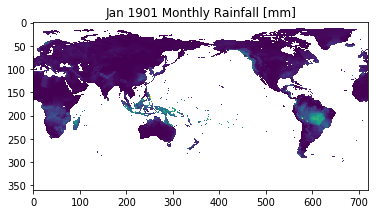

In [11]:
plt.imshow(pr[0]) #data for the first time-step (January 1901)
plt.title('Jan 1901 Monthly Rainfall [mm]')

### 3.2 Visualize on a Map Projection

The matplotlib basemap is used here, which is a library for plotting 2D data on maps in Python. It is similar in functionality to the matlab mapping toolbox, the IDL mapping facilities, GrADS, or the Generic Mapping Tools. PyNGL and CDAT are other libraries that provide similar capabilities in Python (https://matplotlib.org/basemap/users/intro.html).

basemap supports many projecitons:
* Azimuthal Equidistant Projection
* Gnomonic Projection
* Orthographic Projection
* Geostationary Projection
* Near-Sided Perspective Projection
* Mollweide Projection
* ...

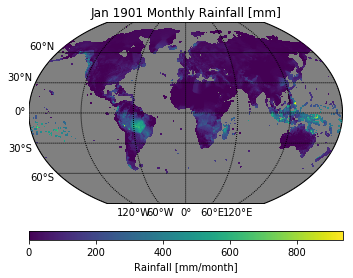

In [12]:
lons, lats = np.meshgrid(lon,lat)

m = Basemap(projection='kav7', lon_0=0)
m.drawmapboundary(fill_color='Gray', zorder=0)
m.drawparallels(np.arange(-90.,99.,30.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,180.,60.), labels=[0,0,0,1])

h = m.pcolormesh(lons,lats,pr[0], shading='flat',latlon=True)
m.colorbar(h, location='bottom', pad="15%", label='Rainfall [mm/month]')

plt.title('Jan 1901 Monthly Rainfall [mm]')

## 4. Work with masked arrays

In the previous section we noticed that our precipitation data-set only has values over land. This is where
masked arrays come into play.

### 4.1 Have a look at pr

In [13]:
#pr # Python automatically created a masked array with the data and the mask

### 4.2 Have a look at the data and the mask separately

In [14]:
pr.data # gives you the data array only

array([[[ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        ..., 
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36]],

       [[ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+3

In [15]:
pr.mask # gives you True where the data is masked (over the ocean) and False where data is available (over land)

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ..., 
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True, 

### 4.3 Create a vector of precipitation data where values are not masked

In [16]:
pr.data[~pr.mask] # the tilde inverts the mask
pr.data

array([[[ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        ..., 
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36]],

       [[ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36, ...,
          -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+36],
        [ -9.96920997e+36,  -9.96920997e+36,  -9.96920997e+3

### 4.4 Create a yearly climatology field from the precipitation data

In [17]:
clim = np.mean(pr, axis=0) # because pr is a masked array, all masked values are ignored in the calculation.
clim.shape

(360L, 720L)

'clim' can be plotted onto a map projection the same way you plotted 'pr[0]' above.

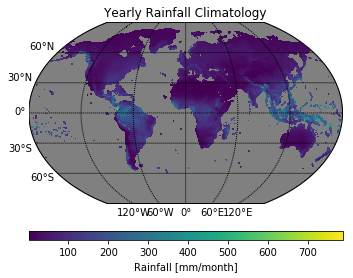

In [18]:
lons, lats = np.meshgrid(lon,lat)
m = Basemap(projection='kav7',lon_0=0)
m.drawmapboundary(fill_color='Gray', zorder=0)
m.drawparallels(np.arange(-90.,99.,30.), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180.,180.,60.), labels=[0,0,0,1])

h = m.pcolormesh(lons,lats,clim, shading='flat',latlon=True)
m.colorbar(h,location='bottom',pad="15%", label='Rainfall [mm/month]')

plt.title('Yearly Rainfall Climatology')

## 5. Calculate and plot the global monthly mean precipitation rate

### 5.1 Define weighting matrix

In [19]:
wgtmat = np.cos(np.tile(abs(lat[:,None])*np.pi/180, (1,len(lon)))) # Dimension: 72x144

### 5.2 Calculate the global monthly mean precipitation rate

In [20]:
mean_pr = np.zeros(pr.shape[0]) # Preallocation
for i in range(pr.shape[0]): # Don’t forget the ‘:’
    mean_pr[i] = np.sum(pr[i] * wgtmat * ~pr.mask[i])/np.sum(wgtmat * ~pr.mask[i])

### 5.3 Plot a time series of monthly rainfall

#### 5.3.1 Give a unit to the global monthly mean precipitation rate

In [21]:
prunit = 'mm/month'

#### 5.3.2 Have a quick look

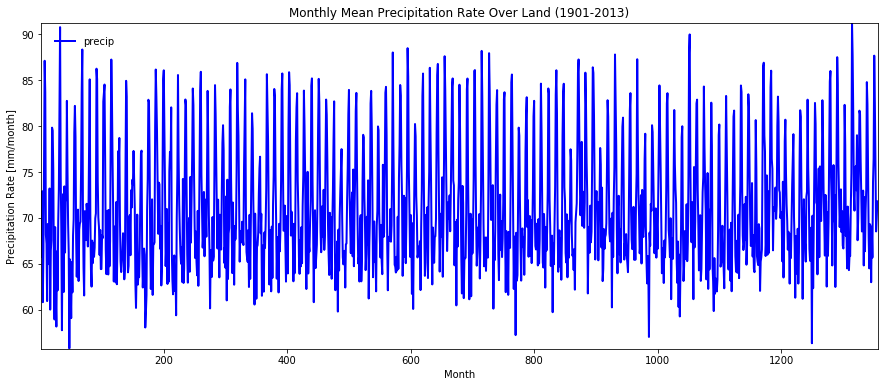

In [22]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

plt.plot(range(1,pr.shape[0]+1), mean_pr, 'b-', label='precip',linewidth=2)
plt.axis([1,pr.shape[0]+1, np.min(mean_pr)-0.05, np.max(mean_pr)+0.05])

plt.xlabel('Month')
plt.ylabel('Precipitation Rate [' + prunit + ']')
plt.title('Monthly Mean Precipitation Rate Over Land (1901-2013)',fontsize=12)
plt.legend(loc=2, borderaxespad=1., frameon=False)

#plt.grid(True)
ax.autoscale_view()

plt.savefig('image/monthly_global_precip.png')

#### 5.3.3 Use dates as x-axis to make image a little pretty

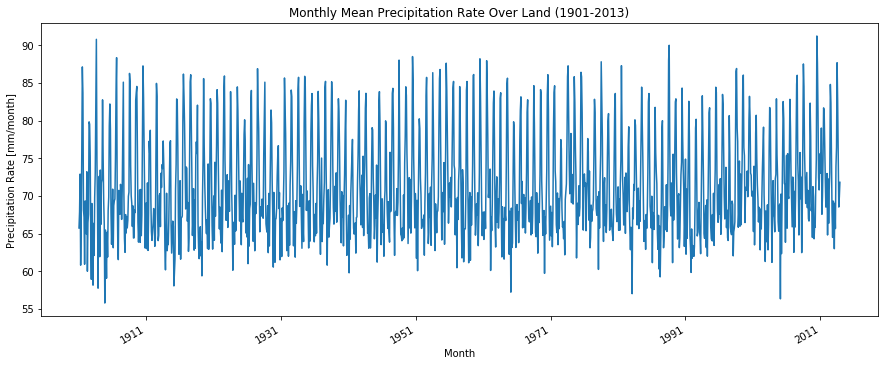

In [23]:
fig, ax = plt.subplots(1)
fig.set_figwidth(15)
fig.set_figheight(6)

# plot mean precipitation
ax.plot(datevar, mean_pr)

# rotate and align the tick labels so they look better
fig.autofmt_xdate()

# use a more precise date string for the x axis locations in the toolbar
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')

# add some docoration
plt.xlabel('Month')
plt.ylabel('Precipitation Rate [' + prunit + ']')
plt.title('Monthly Mean Precipitation Rate Over Land (1901-2013)',fontsize=12)

ax.autoscale_view()

#### 5.3.4 Save the monthly data for future use

In [24]:
np.savez('data/monthlylmeanpr.npz', prunit=prunit, dates=datevar, mean_pr=mean_pr)

### 5.4 Calculate annual mean precipitation rates

Firstly, convert mean_pr data from [months] to [nyr|12|], where months=nyrx12 months/year. This can be done using the  **reshape** function.

Secondly, calculate means of all months whithin a year, which can be done using **np.mean** along the axis=1.

#### 5.4.1 Calculate the numbler of years (should be 113 years)

The months should be divided by 12.

In [25]:
ntimes = mean_pr.shape[0]
nyr = ntimes/12
nyr

113L

#### 5.4.2 Calculate annual mean

In [26]:
mean_pr_reshaped = mean_pr[0:ntimes].reshape((nyr,12))
mean_pr_yr = np.mean(mean_pr_reshaped, axis=1)
mean_pr_yr  # print the results to the screen

array([ 70.49350484,  68.78257052,  69.53434467,  69.40012169,
        68.78172207,  71.38707415,  70.32688904,  71.29754957,
        71.4694519 ,  72.06415749,  69.16141764,  69.9941632 ,
        69.82259146,  67.81409009,  68.9022913 ,  73.30589263,
        72.26861032,  69.33327643,  69.12644641,  70.09183725,
        72.42983119,  71.4552021 ,  70.81370385,  71.4069945 ,
        70.04442565,  71.06697369,  71.97210693,  70.77310562,
        70.1148475 ,  68.40899404,  71.05053139,  71.00876268,
        71.8112793 ,  71.88328393,  70.97576491,  70.68777275,
        71.32013734,  72.04881795,  71.92748356,  69.43444411,
        68.58787537,  71.17703851,  72.04950968,  69.58624967,
        71.73299789,  69.6250515 ,  71.63511054,  70.79787954,
        71.99441878,  72.99011993,  69.61487484,  70.63003508,
        71.45728811,  72.50551987,  73.22703743,  73.75142988,
        70.76542918,  70.14769522,  71.6954333 ,  71.60201804,
        72.28466733,  71.10065842,  70.40934658,  71.20

#### 5.4.3 Get unique years

In [27]:
years = [idx.year for idx in datevar]
years = years[1::12]
print(years[-1])
years[0:13]

2013


[1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913]

#### 5.4.4 Have a quick plot

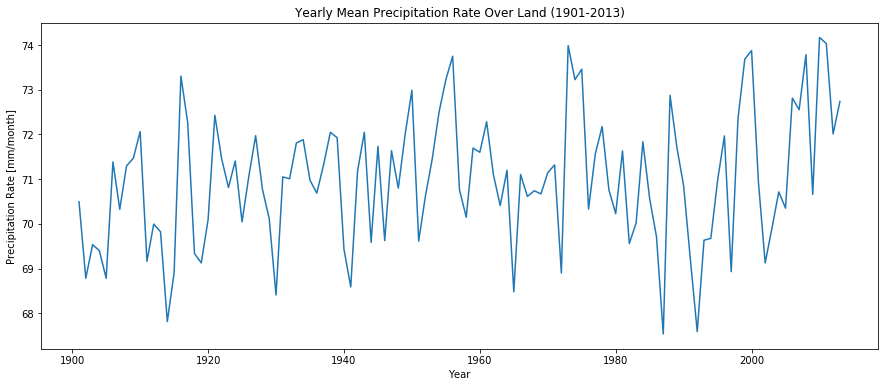

In [28]:
fig, ax = plt.subplots(1)
fig.set_figwidth(15)
fig.set_figheight(6)

# plot mean precipitation
ax.plot(years, mean_pr_yr)

# add some docoration
plt.xlabel('Year')
plt.ylabel('Precipitation Rate [' + prunit + ']')
plt.title('Yearly Mean Precipitation Rate Over Land (1901-2013)',fontsize=12)
#plt.grid(True)

ax.autoscale_view()

## 6. Save and load annual mean precipitation rates

we can save and load several arrays into a single file in uncompressed .npz format using **np.savez**.

The .npz file format is a zipped archive of files named after the variables they contain. The archive is not compressed and each file in the archive contains one variable in .npy format. For a description of the .npy format, see numpy.lib.format or the NumPy Enhancement Proposal http://docs.scipy.org/doc/numpy/neps/npy-format.html

When opening the saved .npz file with load a NpzFile object is returned. This is a dictionary-like object which can be queried for its list of arrays (with the .files attribute), and for the arrays themselves.

### 6.1 Save annual mean precipitation rates

In [29]:
np.savez('data/annualmeanpr.npz', prunit=prunit, years=years, mean_pr_yr=mean_pr_yr)

### 6.2 Load annual mean precipitation rates

In [30]:
npzfile = np.load('data/annualmeanpr.npz')

#### 6.2.1 Check variables in the file

In [31]:
npzfile.files

['mean_pr_yr', 'prunit', 'years']

#### 6.2.2 Check the variable of years

Should the same as 6.4.3

In [32]:
npzfile['years'][0:13]

array([1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911,
       1912, 1913])

## References

http://unidata.github.io/netcdf4-python/

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Kalnay et al.,The NCEP/NCAR 40-year reanalysis project, Bull. Amer. Meteor. Soc., 77, 437-470, 1996.